In [20]:
import numpy as np
import pandas as pd
import scipy.io as sio
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.signal import welch, resample_poly, coherence
from math import gcd

from sklearn.preprocessing import RobustScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score

import hdbscan

sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (8,4)


In [21]:
# --- Paths (edit to your session) ---
HPC_PATH = r"../../data/1/CN/post_trial1_2017-09-28_11-30-59/HPC_100_CH46.continuous.mat"
PFC_PATH = r"../../data/1/CN/post_trial1_2017-09-28_11-30-59/PFC_100_CH11.continuous.mat"
STATES_MAT_PATH = r"../../data/1/CN/post_trial1_2017-09-28_11-30-59/post_trial1_2017-09-28_11-30-59-states.mat"  # optional (1 Hz)

# --- Signal settings (yours) ---
FS_RAW  = 2500
FS_DS   = 500
EPOCH_S = 2.0
OVERLAP = 0.5  # 1 s hop

# --- Bands (yours) ---
BANDS = {
    "delta": (0.5, 4.0),
    "theta": (6.0, 9.0),
    "gamma": (30.0, 80.0),
    "hf":    (80.0, 200.0),
}

# --- Dimensionality + HDBSCAN ---
MAX_PCA_DIMS   = 40
TYPICAL_BOUT_S = 30.0           # ~ 30 s substates
HDBSCAN_METRIC = "euclidean"    # try "cosine" later

SEED = 42
np.random.seed(SEED)


### Loading signals

In [31]:
def load_1d_mat(path):
    m = sio.loadmat(path); best=None
    for k,v in m.items():
        if k.startswith("__"): continue
        a = np.array(v).squeeze()
        if a.ndim==1 and np.issubdtype(a.dtype, np.number):
            if best is None or a.size>best[0]: best=(a.size,a.astype(np.float32))
    if best is None: raise ValueError(f"No 1D numeric vector in {path}")
    return best[1]

def downsample(x, fs_in, fs_out):
    if fs_in==fs_out: return x
    g=gcd(int(fs_in),int(fs_out)); up=int(fs_out//g); down=int(fs_in//g)
    return resample_poly(x, up=up, down=down)

hpc_raw, pfc_raw = load_1d_mat(HPC_PATH), load_1d_mat(PFC_PATH)
L=min(len(hpc_raw),len(pfc_raw)); hpc_raw, pfc_raw = hpc_raw[:L], pfc_raw[:L]
hpc, pfc, fs = downsample(hpc_raw,FS_RAW,FS_DS), downsample(pfc_raw,FS_RAW,FS_DS), FS_DS
print("Downsampled:", len(hpc), "samples @", fs,"Hz")


Downsampled: 1342541 samples @ 500 Hz


In [32]:
def epoch_2ch(hpc, pfc, fs, win_s, overlap):
    win=int(round(win_s*fs)); hop=max(1,int(round(win*(1-overlap))))
    n=min(len(hpc),len(pfc)); starts=np.arange(0,n-win+1,hop,dtype=int)
    ep=np.stack([np.vstack([hpc[s:s+win],pfc[s:s+win]]).T for s in starts],axis=0)  # (N,win,2)
    return ep, starts

epochs, starts = epoch_2ch(hpc, pfc, fs, EPOCH_S, OVERLAP)
t_start_s = starts / fs
print("Epochs:", epochs.shape, "(n_epochs, win_len, 2) | hop =", EPOCH_S*(1-OVERLAP),"s")


Epochs: (2684, 1000, 2) (n_epochs, win_len, 2) | hop = 1.0 s


In [33]:
def features(ep, fs, bands):
    n_ep, win, _ = ep.shape
    nperseg=int(round(1.0*fs)); noverlap=int(round(0.5*nperseg))
    rows=[]
    for i in range(n_ep):
        xh, xp = ep[i,:,0], ep[i,:,1]
        fh,Ph = welch(xh, fs=fs, nperseg=nperseg, noverlap=noverlap, scaling="density")
        fp,Pp = welch(xp, fs=fs, nperseg=nperseg, noverlap=noverlap, scaling="density")
        fc,Cxy= coherence(xh,xp,fs=fs,nperseg=nperseg,noverlap=noverlap)
        r={}
        for name,(fmin,fmax) in bands.items():
            bh=(fh>=fmin)&(fh<=fmax); bp_h=float(np.trapz(Ph[bh],fh[bh])); r[f"HPC_{name}_bp"]=bp_h
            bp=(fp>=fmin)&(fp<=fmax); bp_p=float(np.trapz(Pp[bp],fp[bp])); r[f"PFC_{name}_bp"]=bp_p
        r["HPC_theta_delta"]= r["HPC_theta_bp"]/(r["HPC_delta_bp"]+1e-12)
        r["PFC_theta_delta"]= r["PFC_theta_bp"]/(r["PFC_delta_bp"]+1e-12)
        for name,(fmin,fmax) in bands.items():
            b=(fc>=fmin)&(fc<=fmax); r[f"coh_HPC_PFC_{name}"]= float(np.mean(Cxy[b])) if np.any(b) else 0.0
        rows.append(r)
    df = pd.DataFrame(rows); df.insert(0,"t_start_s",t_start_s); return df

df_feat = features(epochs, fs, BANDS)
print("Feature table:", df_feat.shape); df_feat.head(3)


C:\Users\lenovo\AppData\Local\Temp\ipykernel_36052\1837941204.py:12: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  bh=(fh>=fmin)&(fh<=fmax); bp_h=float(np.trapz(Ph[bh],fh[bh])); r[f"HPC_{name}_bp"]=bp_h
C:\Users\lenovo\AppData\Local\Temp\ipykernel_36052\1837941204.py:13: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  bp=(fp>=fmin)&(fp<=fmax); bp_p=float(np.trapz(Pp[bp],fp[bp])); r[f"PFC_{name}_bp"]=bp_p


Feature table: (2684, 15)


,t_start_s,HPC_delta_bp,PFC_delta_bp,HPC_theta_bp,PFC_theta_bp,HPC_gamma_bp,PFC_gamma_bp,HPC_hf_bp,PFC_hf_bp,HPC_theta_delta,PFC_theta_delta,coh_HPC_PFC_delta,coh_HPC_PFC_theta,coh_HPC_PFC_gamma,coh_HPC_PFC_hf
0,0.0,4300.939331,4323.943726,1532.613174,531.623825,506.658639,1115.718646,554.456454,1050.000820,0.356344,0.122949,0.507846,0.480177,0.533741,0.695727
1,1.0,2486.624207,4930.421753,977.778305,503.210144,471.365335,722.925141,551.341444,891.369025,0.393215,0.102062,0.282106,0.387225,0.398886,0.637913
2,2.0,1884.435974,6534.788818,2535.565552,392.483376,662.068959,992.295672,625.482843,1028.037482,1.345530,0.060061,0.512923,0.525046,0.381501,0.641100


## Downsample to 500 Hz
Lower size/noise, still covers 0.5–200 Hz bands clearly.


Downsampled shapes: (1342541,) (1342541,) | fs: 500


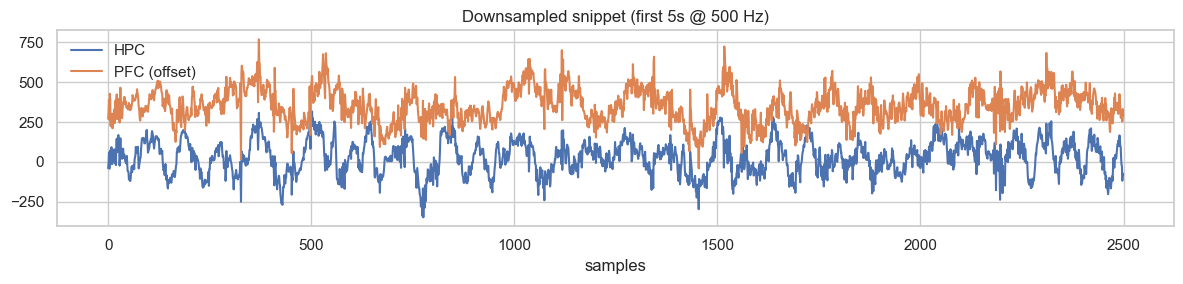

In [24]:
def downsample_sig(x, fs_in, fs_out):
    if fs_in == fs_out: 
        return x
    g = gcd(int(fs_in), int(fs_out))
    up = int(fs_out // g)
    down = int(fs_in  // g)
    return resample_poly(x, up=up, down=down)

hpc = downsample_sig(hpc_raw, FS_RAW, FS_DS)
pfc = downsample_sig(pfc_raw, FS_RAW, FS_DS)
fs  = FS_DS

print("Downsampled shapes:", hpc.shape, pfc.shape, "| fs:", fs)
N = int(5 * fs)
off = pfc[:N].std() * 3
plt.figure(figsize=(12,3))
plt.plot(hpc[:N], label="HPC")
plt.plot(pfc[:N] + off, label="PFC (offset)")
plt.title(f"Downsampled snippet (first 5s @ {fs} Hz)")
plt.xlabel("samples"); plt.legend(); plt.tight_layout(); plt.show()


In [25]:
def epoch_2ch(hpc, pfc, fs, win_s, overlap):
    win = int(round(win_s * fs))
    hop = max(1, int(round(win * (1 - overlap))))
    n   = min(len(hpc), len(pfc))
    starts = np.arange(0, n - win + 1, hop, dtype=int)
    ep = np.stack([np.vstack([hpc[s:s+win], pfc[s:s+win]]).T for s in starts], axis=0)  # (n_epochs, win, 2)
    return ep, starts

epochs, starts = epoch_2ch(hpc, pfc, fs, EPOCH_S, OVERLAP)
t_start_s = starts / fs
print("Epochs:", epochs.shape, "(n_epochs, win_len, 2) | hop:", int(EPOCH_S*(1-OVERLAP)), "s")


Epochs: (2684, 1000, 2) (n_epochs, win_len, 2) | hop: 1 s


## Features per epoch (= “brainprint” of each 2s slice)
- HPC & PFC bandpowers: δ, θ(6–9), γ, HF
- θ/δ ratio per channel
- HPC↔PFC coherence per band

We’ll inspect distributions after extraction to catch scaling/outliers.


In [26]:
def compute_epoch_features(ep, fs, bands):
    n_ep, win, _ = ep.shape
    nperseg = int(round(1.0 * fs))       # 1 s segment inside each 2 s epoch
    noverlap = int(round(0.5 * nperseg)) # 50% overlap

    rows = []
    for i in range(n_ep):
        x_hpc = ep[i,:,0]
        x_pfc = ep[i,:,1]

        f_h, P_h = welch(x_hpc, fs=fs, nperseg=nperseg, noverlap=noverlap, scaling="density")
        f_p, P_p = welch(x_pfc, fs=fs, nperseg=nperseg, noverlap=noverlap, scaling="density")
        f_c, Cxy = coherence(x_hpc, x_pfc, fs=fs, nperseg=nperseg, noverlap=noverlap)

        feat = {}
        for ch_name, f, P in [("HPC", f_h, P_h), ("PFC", f_p, P_p)]:
            cache = {}
            for name, (fmin, fmax) in bands.items():
                band = (f >= fmin) & (f <= fmax)
                bp = np.trapz(P[band], f[band])
                feat[f"{ch_name}_{name}_bp"] = bp
                cache[name] = bp
            feat[f"{ch_name}_theta_delta"] = cache["theta"] / (cache["delta"] + 1e-12)

        for name, (fmin, fmax) in bands.items():
            band = (f_c >= fmin) & (f_c <= fmax)
            feat[f"coh_HPC_PFC_{name}"] = float(np.mean(Cxy[band])) if np.any(band) else 0.0

        rows.append(feat)

    df_feat = pd.DataFrame(rows)
    df_feat.insert(0, "t_start_s", t_start_s)
    return df_feat

df_feat = compute_epoch_features(epochs, fs, BANDS)
print("Feature table:", df_feat.shape)
df_feat.head(3)


C:\Users\lenovo\AppData\Local\Temp\ipykernel_36052\1336033156.py:20: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  bp = np.trapz(P[band], f[band])


Feature table: (2684, 15)


,t_start_s,HPC_delta_bp,HPC_theta_bp,HPC_gamma_bp,HPC_hf_bp,HPC_theta_delta,PFC_delta_bp,PFC_theta_bp,PFC_gamma_bp,PFC_hf_bp,PFC_theta_delta,coh_HPC_PFC_delta,coh_HPC_PFC_theta,coh_HPC_PFC_gamma,coh_HPC_PFC_hf
0,0.0,4300.939331,1532.613174,506.658639,554.456454,0.356344,4323.943726,531.623825,1115.718646,1050.000820,0.122949,0.507846,0.480177,0.533741,0.695727
1,1.0,2486.624207,977.778305,471.365335,551.341444,0.393215,4930.421753,503.210144,722.925141,891.369025,0.102062,0.282106,0.387225,0.398886,0.637913
2,2.0,1884.435974,2535.565552,662.068959,625.482843,1.345530,6534.788818,392.483376,992.295672,1028.037482,0.060061,0.512923,0.525046,0.381501,0.641100


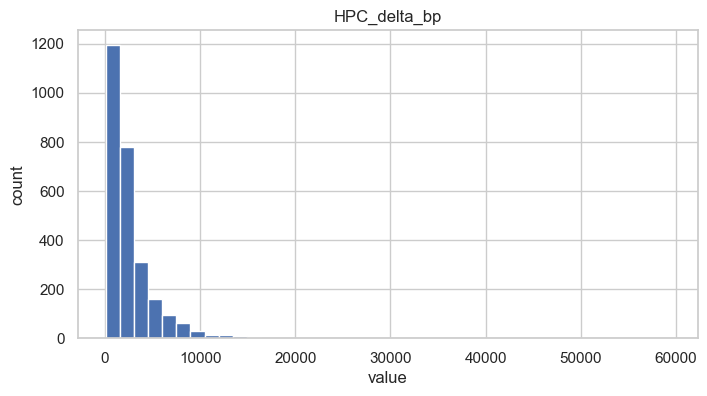

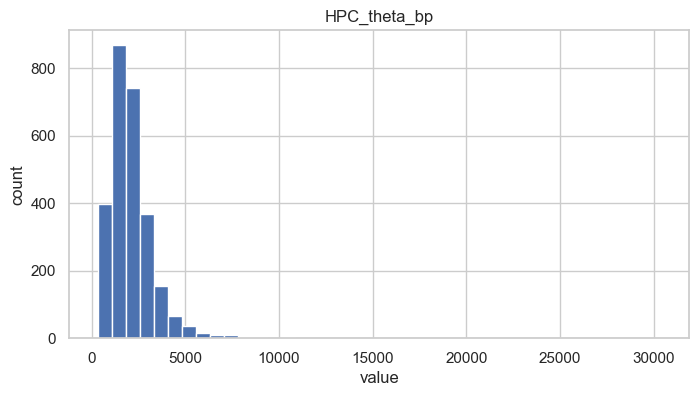

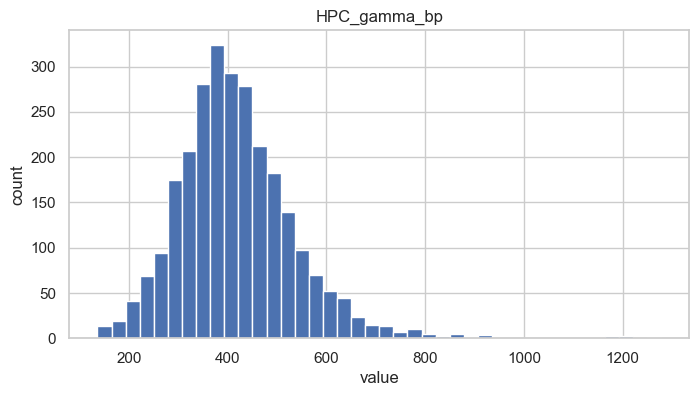

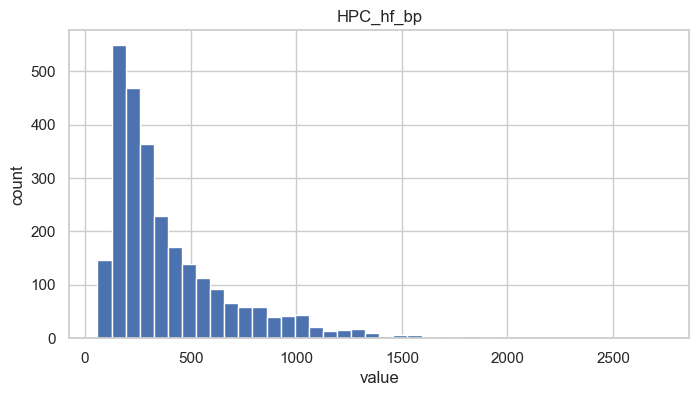

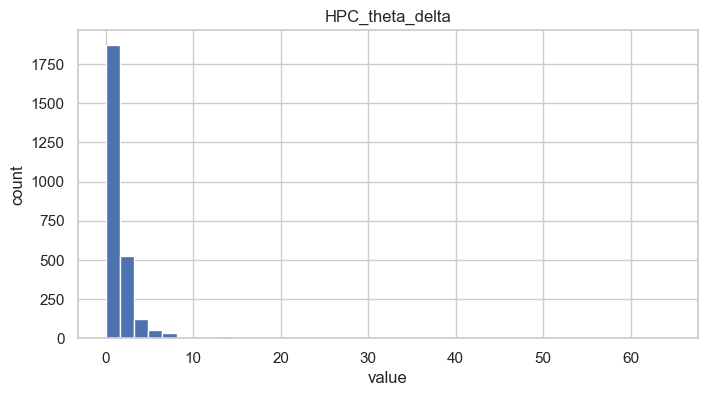

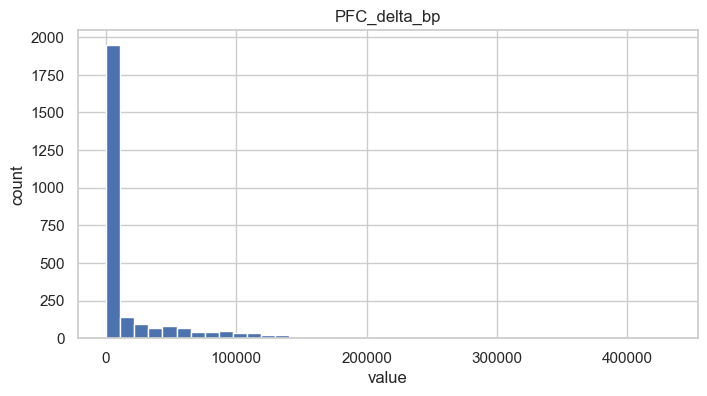

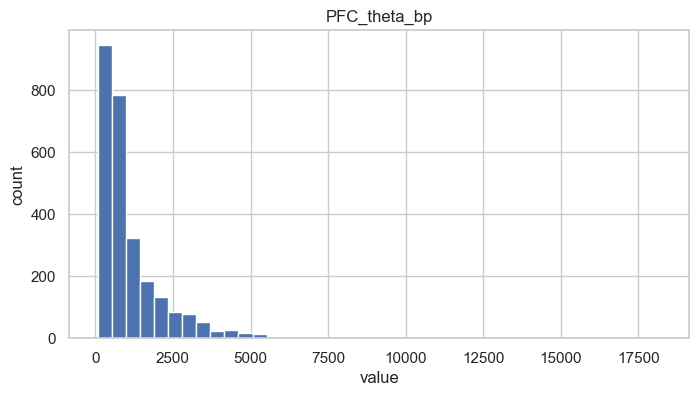

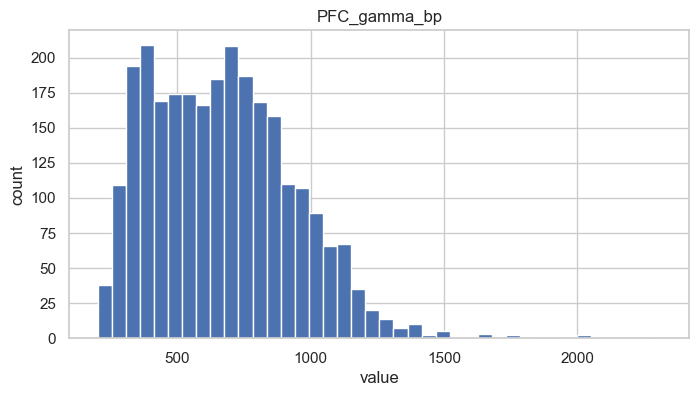

In [27]:
plot_cols = [c for c in df_feat.columns if any(k in c.lower() for k in
                ["delta_bp","theta_bp","gamma_bp","hf_bp","theta_delta","coh_hpc_pfc"])][:8]
for c in plot_cols:
    plt.figure()
    df_feat[c].hist(bins=40)
    plt.title(c); plt.xlabel("value"); plt.ylabel("count")
    plt.show()


## RobustScaler → PCA (≤ 40 dims)
Robust to outliers; compress & denoise before HDBSCAN.


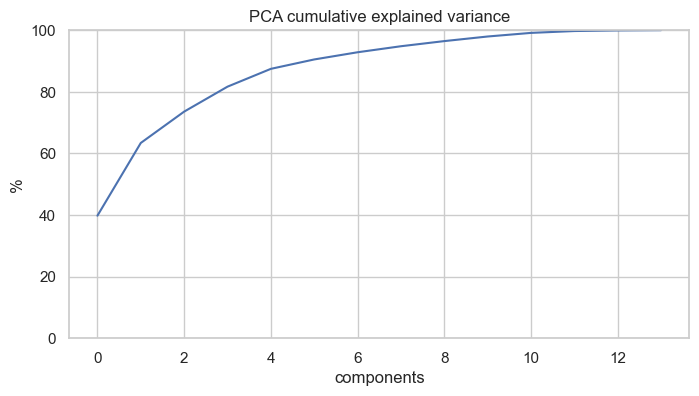

PCA dims: 14 | total explained variance: 1.0


In [28]:
X = df_feat.drop(columns=["t_start_s"]).values
scaler = RobustScaler()
Xr = scaler.fit_transform(X)

pca = PCA(n_components=min(MAX_PCA_DIMS, Xr.shape[1]), random_state=SEED)
Xp  = pca.fit_transform(Xr)

expl = pca.explained_variance_ratio_
plt.figure()
plt.plot(np.cumsum(expl) * 100)
plt.title("PCA cumulative explained variance")
plt.xlabel("components"); plt.ylabel("%"); plt.ylim(0, 100); plt.show()

print("PCA dims:", Xp.shape[1], "| total explained variance:", round(expl.sum(), 3))


## HDBSCAN (with prediction_data, as recommended)
- `min_cluster_size` ≈ how many 2s epochs a substate should have (~30/2×3 ≈ 45–50).
- `prediction_data=True` enables **soft clustering** & **approximate_predict** later.  
(See the official docs’ tutorials on soft clustering and prediction.) :contentReference[oaicite:4]{index=4}


In [29]:
min_cluster_size0 = max(25, int(TYPICAL_BOUT_S / EPOCH_S * 3))  # ~45 → ~50
print("HDBSCAN min_cluster_size0 =", min_cluster_size0)

clusterer = hdbscan.HDBSCAN(
    min_cluster_size=min_cluster_size0,
    min_samples=None,            # start simple; tune if needed
    metric=HDBSCAN_METRIC,
    prediction_data=True,        # enables soft membership & approx predict
    core_dist_n_jobs=-1
).fit(Xp)

labels = clusterer.labels_
proba  = clusterer.probabilities_

k = len(set(labels) - {-1})
noise = (labels == -1).mean()
print(f"Clusters: {k} | Noise: {noise*100:.1f}%")


HDBSCAN min_cluster_size0 = 45


c:\Users\lenovo\Sandman\.sandman\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\lenovo\Sandman\.sandman\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Clusters: 0 | Noise: 100.0%


## Quick diagnostics
- Probability histogram → confident cores vs boundary points
- Cluster sizes (excl. noise)
- Timeline (should form contiguous runs)


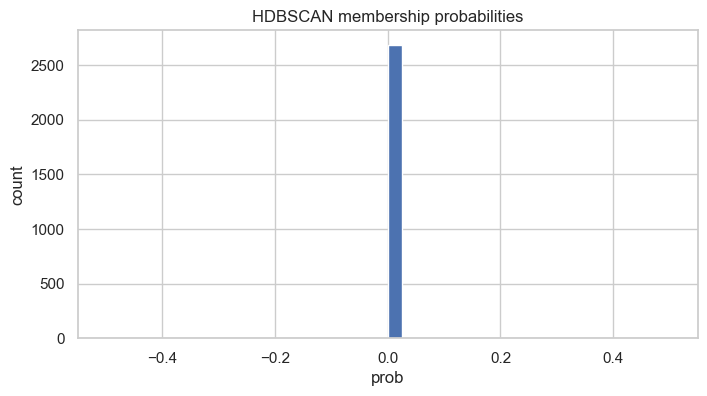

Cluster sizes: {}


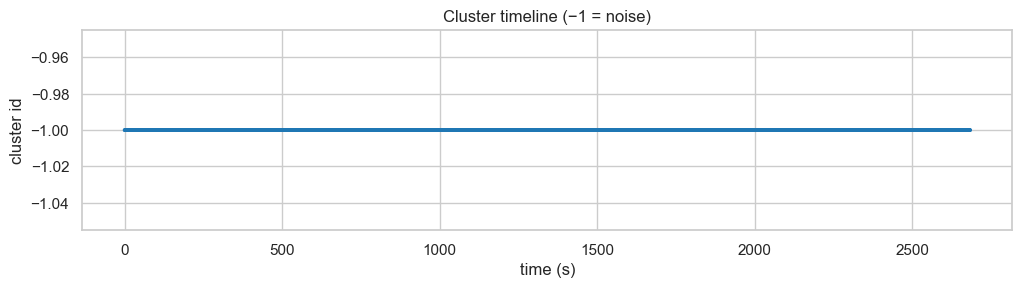

In [30]:
plt.figure(); plt.hist(proba, bins=40); plt.title("HDBSCAN membership probabilities"); plt.xlabel("prob"); plt.ylabel("count"); plt.show()

vals, counts = np.unique(labels[labels!=-1], return_counts=True)
print("Cluster sizes:", dict(zip(vals.tolist(), counts.tolist())))

order = np.argsort(t_start_s)
plt.figure(figsize=(12,2.6))
plt.scatter(t_start_s[order], labels[order], s=3, c=labels[order], cmap="tab20")
plt.title("Cluster timeline (−1 = noise)"); plt.xlabel("time (s)"); plt.ylabel("cluster id"); plt.show()
